In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from scipy.special import logsumexp
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import sys
import math

sys.path.append('..')
sys.path.append('../vbpi-torch/rooted')
from VIPR import VIPR

from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

In [2]:
sns.set_style("whitegrid")  # Options: white, dark, whitegrid, darkgrid, ticks
sns.set_palette("muted")    # Options: deep, muted, bright, pastel, dark, colorblind

In [3]:
models = ["VBPI_10","VBPI_20","reinforce","reparam","VIMCO"]

colors = {"BEAST":plt.cm.tab10(0),
          "VBPI_10":plt.cm.tab10(1),
          "VBPI_20":plt.cm.tab10(2),
          "reinforce":plt.cm.tab10(3),
          "reparam":plt.cm.tab10(4),
          "VIMCO":plt.cm.tab10(5)}

linestyles = {"BEAST":"-",
              "VBPI_10":"--",
              "VBPI_20":"-.",
              "reinforce":":",
              "reparam":"--",
              "VIMCO":"-."}

experiement = "sim"
#experiement = "COVID"

if experiement == "sim":
    data_sets = ["taxa_00008","taxa_00016","taxa_00032",
                 "taxa_00064","taxa_00128","taxa_00256",
                 "taxa_00512"]
    ntaxa = [8,16,32,64,128,256,512]
else:
    data_sets = ["DS14_6","DS14_12","DS14_24","DS14_48","DS14_72"]
    ntaxa = [6,12,24,48,72]

In [4]:
# load in VBPI

VBPI_runtimes = {}
VBPI_lbs = {}
VBPI_iters = {}
avg_runtimes = {}
CPD_params = {}

legend = []

for ds in data_sets:
    
    print(ds)
    
    avg_runtimes[ds] = {}
    VBPI_dir = '../../results/'+ds+'/'
    VBPI_runtimes[ds] = {}
    VBPI_lbs[ds] = {}
    VBPI_iters[ds] = {}
    
    # get number of params
    data, taxa = loadData('../../dat/'+ds+'/'+ds+'.nexus', 'nexus')
    mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../../dat/'+ds+'/'+ds+'_fixed_pop_support_short_run', 'nexus', burnin=250)
    rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
    emp_tree_freq = None
    sample_info = [0.0 for taxon in taxa]
    temp_model = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
                 emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
                 sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
                 log_pop_size_offset=math.log(5.0))
    CPD_params[ds] = len(temp_model.tree_model.CPDs)
    
    for bs in ["10","20"]:

        VBPI_pref = "mcmc_vimco_%s_0.001_psp_fixed_pop_fixed_rate_"%bs
        files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
        files = [x for x in files if x.endswith(".pt")]
        file = max(files)

        VBPI_runtimes[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_run_time.npy"))
        VBPI_lbs[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_test_lb.npy"))
        VBPI_iters[ds][bs] = np.load(VBPI_dir+file.replace(".pt","_iters.npy"))
        
        avg_runtimes[ds]["VBPI_%s"%bs] = sum(VBPI_runtimes[ds][bs]) / VBPI_iters[ds][bs][-1]

taxa_00008


/Users/evsi8432/Documents/Research/VBPI-matrix/src/computational_complexity/../vbpi-torch/rooted/phyloModel.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  self.L, self.site_counts = map(torch.FloatTensor, self.initialCLV(data, unique_site=True))


taxa_00016
taxa_00032
taxa_00064
taxa_00128
taxa_00256
taxa_00512


In [5]:
# my models
optims = {}

for ds in data_sets:
    
    optims[ds] = {}
    
    for model in ["reinforce","reparam","VIMCO"]:
            
        optim_dir = '../../results/'+ds+'/'
        optim_pref = ds+'_'+model+'_0.03_0'
        files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
        
        if files:
            fname = optim_dir + max(files)
            with open(fname, 'rb') as f:
                optims[ds][model] = pickle.load(f)
            avg_runtimes[ds][model] = sum(optims[ds][model].run_times[1:]) / optims[ds][model].epochs[-1]
        else:
            optims[ds][model] = None
            avg_runtimes[ds][model] = np.nan

# Plot:
 - time / likelihood evaluation vs number of taxa
 - time / likelihood evaluation vs number of sites

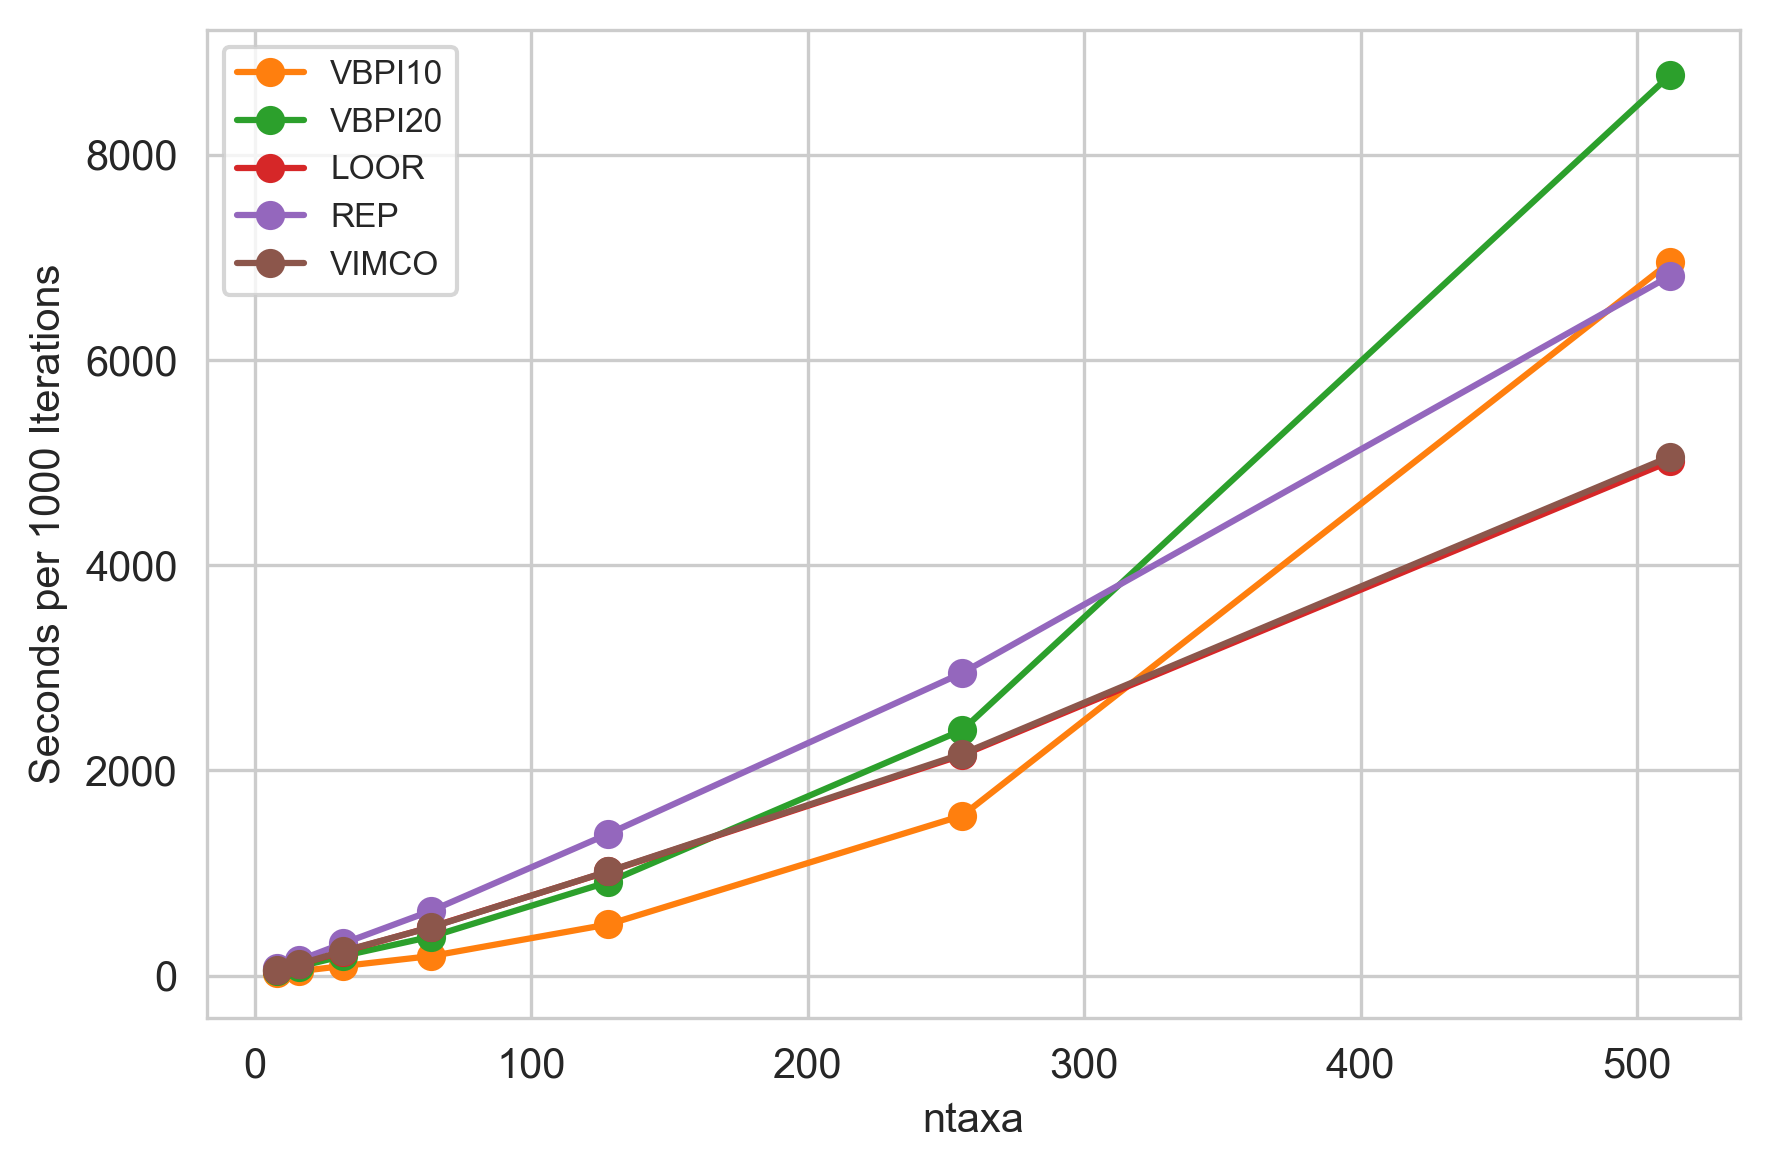

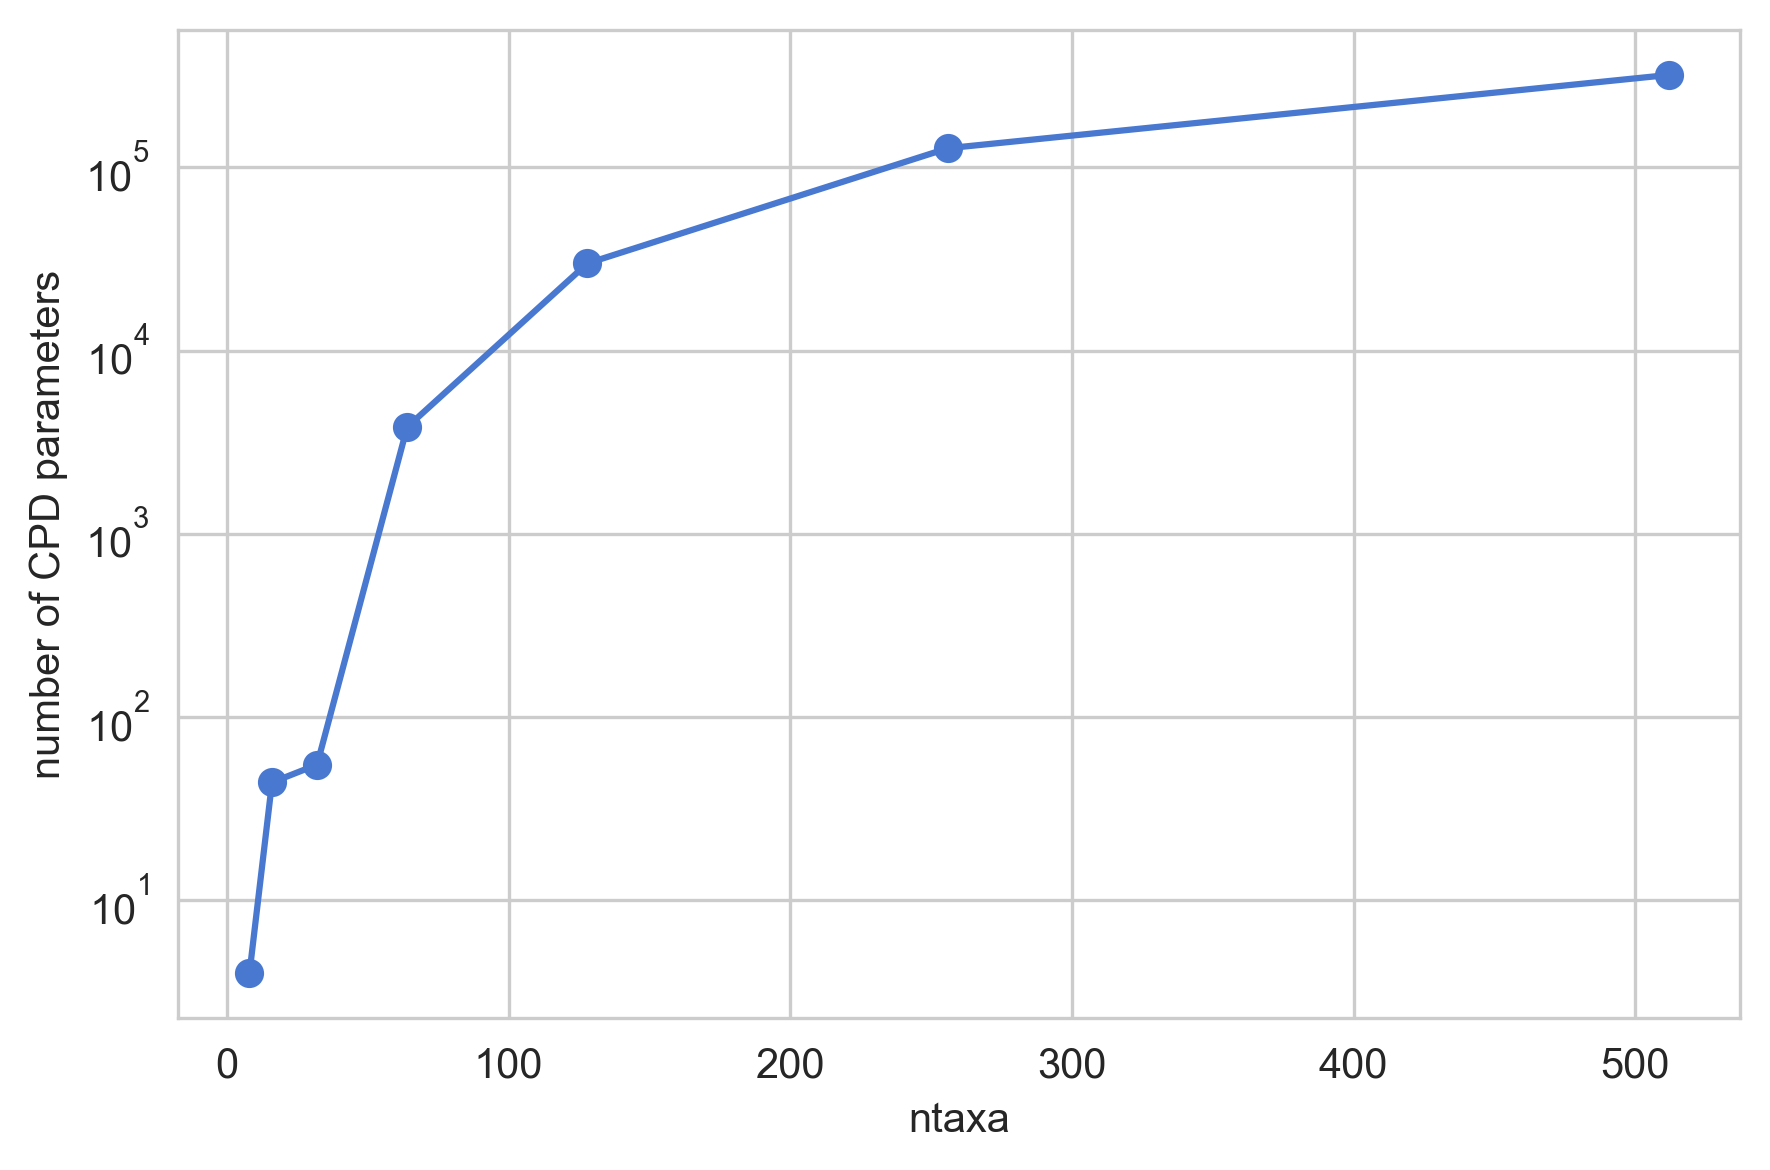

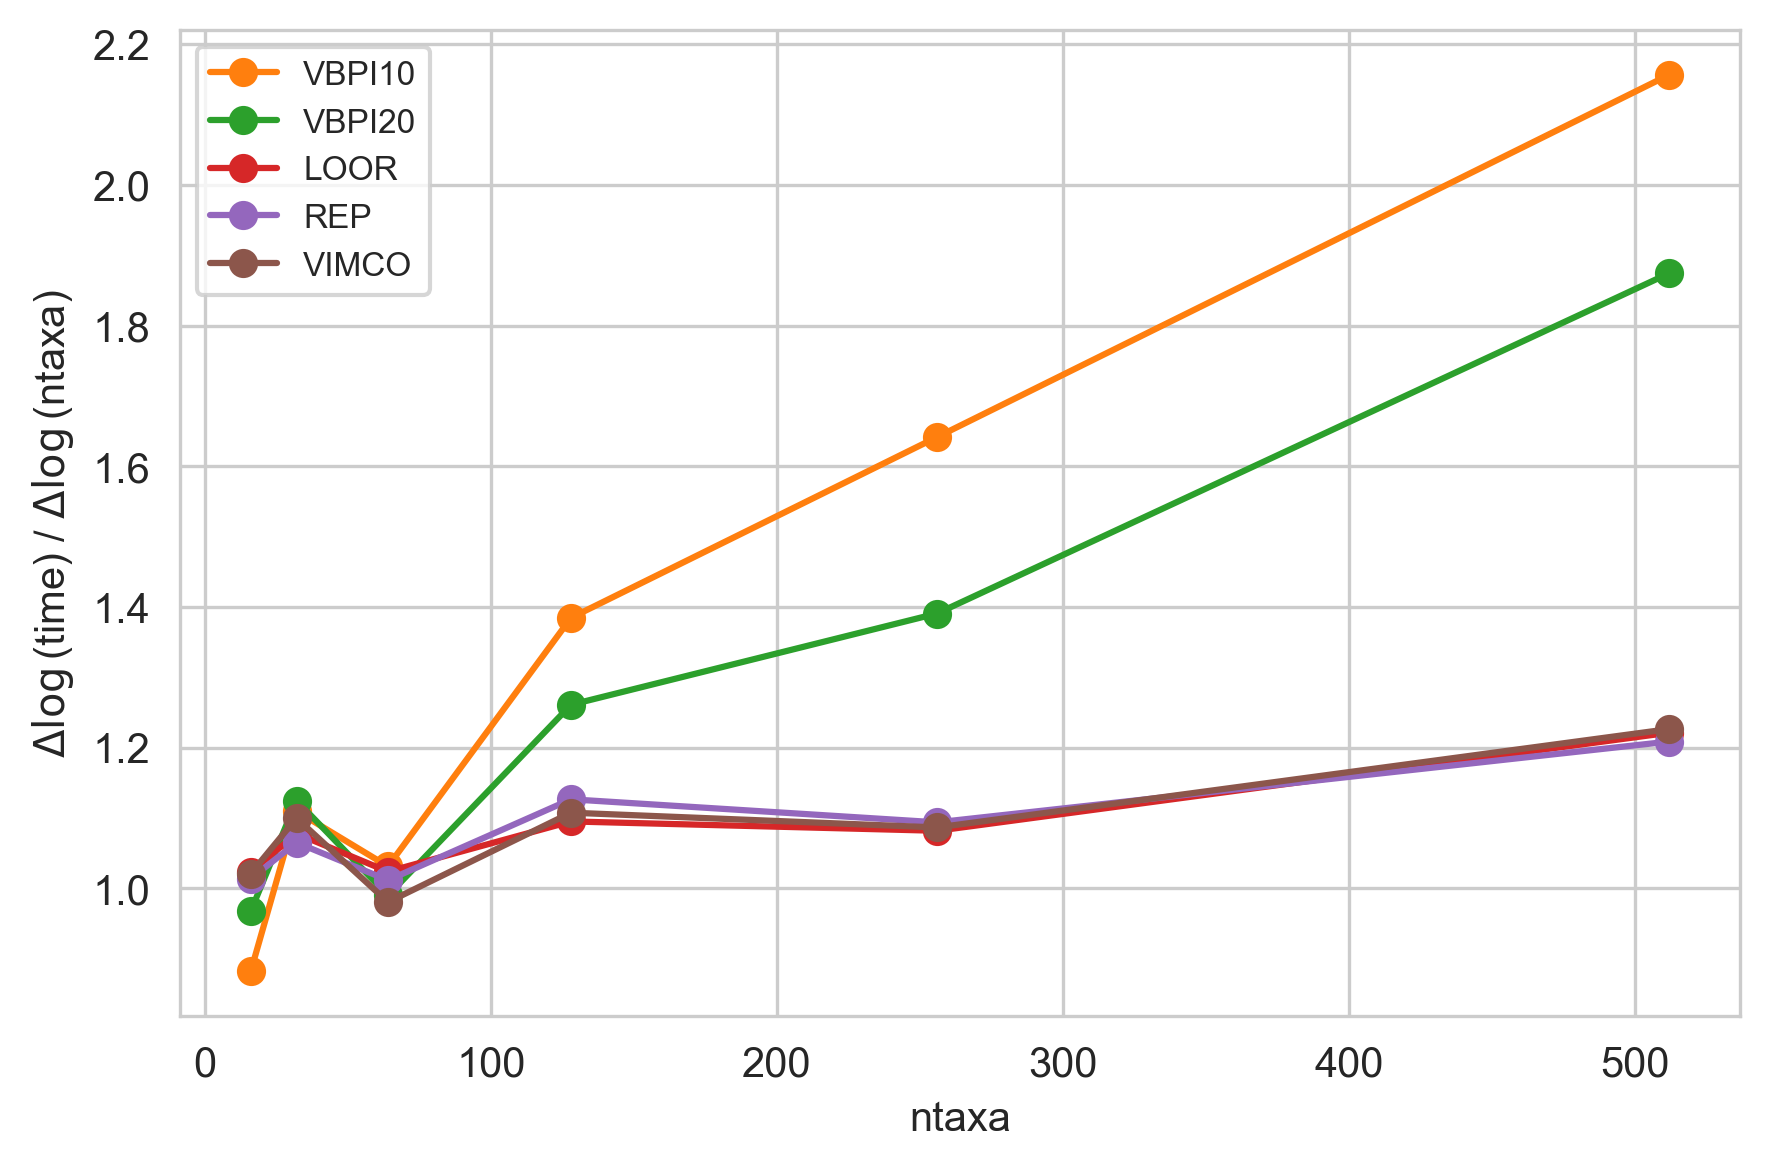

In [12]:
journal = "ICML"

if journal == "Neurips":
    fig = plt.figure(figsize=(5, 3), dpi = 300)
    fname = "../../plt/sec_v_ntaxa-n_%s.png"%experiement
else:
    fig = plt.figure(figsize=(6, 4), dpi = 300)
    fname = "../../plt/sec_v_ntaxa_%s.png"%experiement
    
for model in models:
    plt.plot(ntaxa,[1000*avg_runtimes[x][model] for x in data_sets],color = colors[model], marker = "o")

plt.ylabel("Seconds per 1000 Iterations")
plt.xlabel("ntaxa")
plt.legend(["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
#plt.yscale("log")
#plt.xscale("log")
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

###

fig = plt.figure(figsize=(6, 4), dpi = 300)
fname = "../../plt/CPD_v_ntaxa_%s.png"%experiement
plt.plot(ntaxa,list(CPD_params.values()),marker = "o")

plt.ylabel("number of CPD parameters")
plt.xlabel("ntaxa")
plt.yscale("log")
#plt.xscale("log")
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

###

def dlogy_dlogx(y,x):
    return [(np.log(y[i+1])-np.log(y[i])) / (np.log(x[i+1])-np.log(x[i])) for i in range(len(y)-1)]

if journal == "Neurips":
    fig = plt.figure(figsize=(5, 3), dpi = 300)
    fname = "../../plt/dydx_v_ntaxa-n_%s.png"%experiement
else:
    fig = plt.figure(figsize=(6, 4), dpi = 300)
    fname = "../../plt/dydx_v_ntaxa_%s.png"%experiement

for model in models:
    plt.plot(ntaxa[1:],dlogy_dlogx([avg_runtimes[x][model] for x in data_sets],ntaxa),color = colors[model], marker = "o")

plt.ylabel(r"$\Delta \log$(time) / $\Delta \log$(ntaxa)")
plt.xlabel("ntaxa")
plt.legend(["VBPI10","VBPI20","LOOR","REP","VIMCO"],prop={'size': 8})
plt.tight_layout()
plt.savefig(fname, dpi = 300)
plt.show()

In [10]:
print(ntaxa)
for model in models:
    print(model)
    print([1000*avg_runtimes[x][model] for x in data_sets])

print("")
print(list(CPD_params.values()))

[8, 16, 32, 64, 128, 256, 512]
VBPI_10
[23.576018571853638, 43.44864106178284, 93.76379776000977, 191.62683773040771, 500.316667954127, 1560.878930091858, 6958.089911937714]
VBPI_20
[45.00517559051514, 88.00755071640015, 191.9189248085022, 381.14650547504425, 913.4367442131042, 2395.013060569763, 8780.355100631714]
reinforce
[54.53302409913805, 110.82445277108087, 233.93607801861233, 475.6420384134565, 1016.0969964663187, 2150.7644307613373, 5014.220058917999]
reparam
[74.38025130165948, 150.17720169491238, 314.20425335566205, 633.4502196311951, 1383.0477579434712, 2951.9124794006348, 6822.409880161285]
VIMCO
[55.07046778996785, 111.75804297129314, 239.5376764403449, 472.6120328903198, 1018.3724323908488, 2162.624317407608, 5060.061519145966]

[4, 44, 55, 3826, 29939, 127217, 319533]
